In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import math

In [10]:
df = pd.read_csv('./data/GOOG_data.csv')

In [11]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.dropna()

print(df.head())
print(df.info())

        date     open    high     low   close  volume  Name
0 2014-03-27  568.000  568.00  552.92  558.46   13052  GOOG
1 2014-03-28  561.200  566.43  558.67  559.99   41003  GOOG
2 2014-03-31  566.890  567.00  556.93  556.97   10772  GOOG
3 2014-04-01  558.710  568.45  558.71  567.16    7932  GOOG
4 2014-04-02  565.106  604.83  562.19  567.00  146697  GOOG
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    975 non-null    datetime64[ns]
 1   open    975 non-null    float64       
 2   high    975 non-null    float64       
 3   low     975 non-null    float64       
 4   close   975 non-null    float64       
 5   volume  975 non-null    int64         
 6   Name    975 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 53.4+ KB
None


In [35]:
# --- Select features ---
features = ['open', 'high', 'low', 'close', 'volume']
data = df[features].values
print("Data shape:", data.shape)

Data shape: (975, 5)


In [36]:
# --- Scale all features ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [37]:
SEQ_LEN = 60  # last 60 days to predict next day's Close

def create_sequences_multifeature(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])         # all 5 features for past 60 days
        y.append(data[i, 3])                # index 3 = 'close' column target
    return np.array(X), np.array(y)

X, y = create_sequences_multifeature(scaled_data, SEQ_LEN)
print("X shape:", X.shape, "y shape:", y.shape)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


X shape: (915, 60, 5) y shape: (915,)


In [54]:
# ---- Build LSTM model ----
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

e:\Navttc_AI-ML\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
EPOCHS = 100
BATCH_SIZE = 32

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[es],
                    verbose=1)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/ste

In [56]:
# Predict
pred_scaled = model.predict(X_test)

# To inverse scale 'close', we create dummy arrays for proper shape
pred_full = np.zeros((len(pred_scaled), data.shape[1]))
pred_full[:, 3] = pred_scaled[:, 0]  # fill 'close' column
y_test_full = np.zeros((len(y_test), data.shape[1]))
y_test_full[:, 3] = y_test

pred = scaler.inverse_transform(pred_full)[:, 3]
y_test_unscaled = scaler.inverse_transform(y_test_full)[:, 3]

# Evaluation
rmse = math.sqrt(mean_squared_error(y_test_unscaled, pred))
mae = mean_absolute_error(y_test_unscaled, pred)
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
RMSE: 16.307, MAE: 11.716


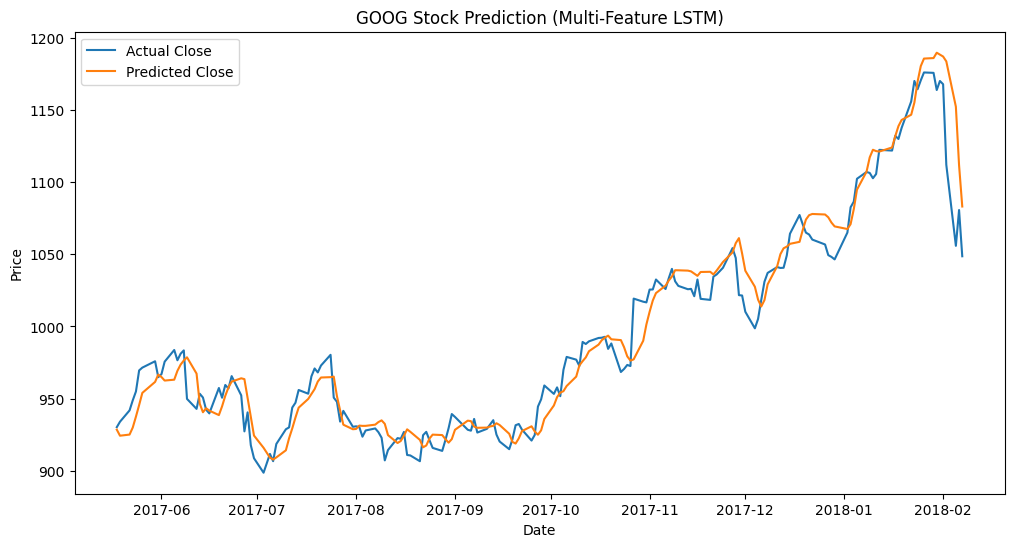

In [57]:
# ---- Plot ----
test_dates = df['date'].iloc[SEQ_LEN + split:SEQ_LEN + split + len(y_test)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_unscaled, label='Actual Close')
plt.plot(test_dates, pred, label='Predicted Close')
plt.title("GOOG Stock Prediction (Multi-Feature LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
